# Gender distribution across the years

In order to decide the gender of a person, the `gender_guesser` library can be used to analyse the first name. Running
```python
import sys
!{sys.executable} -m pip install gender_guesser --user
```
should install the package.

In [5]:
import gender_guesser.detector as gender # Gender detector for first names.
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import timer

## Across time

In [6]:
df = pd.read_json("imdb_dataset_parsed.json")

# Keep only useful columns and remove NaNs.
df = pd.DataFrame(df[['year', 'actors', 'directors']].dropna())

df['year'] = df['year'].astype(int)

In [7]:
# Keep only first three (protagonists) actors for each film.
def createProtagonists(row):
    names_list = row['actors']
    return names_list[:3]

df['protagonists'] = df.apply(lambda row: createProtagonists(row), axis = 1) 

In [ ]:
# Aggregate entries by year.
df = df.groupby('year', as_index = False).agg({'actors':'sum',
                                               'directors':'sum',
                                               'protagonists':'sum'})

# 2019 has very few entries, drop that row.
df = df[df['year'] != 2019]

In [ ]:
df.head()

In [2]:
def malePercentage(row, column_name):
    names_list = row[column_name]
    genders = []
    
    # Load gender detector.
    d = gender.Detector(case_sensitive = False)
    
    for name in names_list:
        name = name.split(' ')
        # Transforms names like ['J.', 'Stuart', 'Blackton'] in
        # ['Stuart', 'Blackton'].
        name = [x for x in name if not x.endswith(".")]
        # Some names might now be empty.
        if name:
            genders.append(d.get_gender(name[0]))
        
    # Consider only 'male' or 'female' results,
    # excluding 'unknown', 'mostly_male' and 'mostly_female'.
    genders = list(filter(lambda gen: gen == 'male' or 
                          gen == 'female', genders))
    
    if len(genders) > 0:
        return genders.count('male')/len(genders)
    else:
        return np.nan

In [ ]:
df['act_male_perc'] = df.apply(lambda row:
                               malePercentage(row, 'actors'), axis = 1)
df['dir_male_perc'] = df.apply(lambda row:
                               malePercentage(row, 'directors'), axis = 1)
df['pro_male_perc'] = df.apply(lambda row:
                               malePercentage(row, 'protagonists'),axis = 1)

In [ ]:
df.head()

In [ ]:
df.plot(x = 'year', y = 'act_male_perc', ylim = (0, 1))

Some useful info for annotation:
 * 1913: Alice Guy-Blaché, French filmmaker. The first woman to direct a film. Here with "Dick Whittington and his Cat" an _elaborate and spectacular production adapted from Old English fairy tale!_;
 * 2008: Kathryn Bigelow, first woman to win best director Oscar for "The Hurt Locker";

In [ ]:
df.plot(x = 'year', y = 'dir_male_perc', ylim = (0, 1))

In [ ]:
df.plot(x = 'year', y = 'pro_male_perc', ylim = (0, 1))

In [ ]:
#df.drop(columns = ['actors', 'directors']).to_json("gender.json",
#                                                   orient = 'records')

## Last years

In [4]:
df = pd.read_json("imdb_dataset_parsed.json")

# Keep only useful columns and remove NaNs.
df = pd.DataFrame(df[['year', 'actors', 'directors']].dropna())

df['year'] = df['year'].astype(int)

df = pd.DataFrame(df[df['year'] > 1999])

In [5]:
def directorGender(row):
    director_list = row['directors']
    genders = []
    
    # Load gender detector.
    d = gender.Detector(case_sensitive = False)
    
    for name in director_list:
        name = name.split(' ')
        # Transforms names like ['J.', 'Stuart', 'Blackton'] in
        # ['Stuart', 'Blackton'].
        name = [x for x in name if not x.endswith(".")]
        # Some names might now be empty.
        if name:
            genders.append(d.get_gender(name[0]))
        
    # Consider only 'male' or 'female' results,
    # excluding 'unknown', 'mostly_male' and 'mostly_female'.
    genders = list(filter(lambda gen: gen == 'male' or 
                          gen == 'female', genders))
    
    if len(genders) > 0:
        if genders.count('male')/len(genders) > 0.5:
            return "male"
        else:
            return "female"
    else:
        return np.nan

In [6]:
# approx 2h45min for this cell.
with timer.codeTimer("Director genders"):
    df['dir_gen'] = df.apply(lambda row:
                             directorGender(row), axis = 1)

Executed 'Director genders'.  Elapsed time: 9915.071698s


In [7]:
#df.to_pickle('gender_df.pkl')

In [52]:
gender_df = pd.read_pickle("gender_df.pkl").dropna()
gender_df['protagonists'] = gender_df.apply(lambda row: createProtagonists(row), axis = 1) 
gender_df['n_movies'] = 1
gender_df['n_actors'] = gender_df['actors'].apply(lambda row: len(row))
gender_df['n_pro'] = gender_df['protagonists'].apply(lambda row: len(row))
gender_df.head()

,year,actors,directors,dir_gen,protagonists,n_movies,n_actors,n_pro
0,2018,"[Chris Hemsworth, Michael Shannon, Michael Peñ...",[Nicolai Fuglsig],male,"[Chris Hemsworth, Michael Shannon, Michael Peña]",1,15,3
3,2017,"[Hugh Jackman, Patrick Stewart, Dafne Keen, Bo...",[James Mangold],male,"[Hugh Jackman, Patrick Stewart, Dafne Keen]",1,15,3
5,2018,"[Jodie Foster, Sterling K. Brown, Sofia Boutel...",[Drew Pearce],male,"[Jodie Foster, Sterling K. Brown, Sofia Boutella]",1,15,3
8,2014,"[Ralph Fiennes, F. Murray Abraham, Mathieu Ama...",[Wes Anderson],male,"[Ralph Fiennes, F. Murray Abraham, Mathieu Ama...",1,15,3
11,2011,"[Chris Evans, Hayley Atwell, Sebastian Stan, T...",[Joe Johnston],male,"[Chris Evans, Hayley Atwell, Sebastian Stan]",1,15,3


In [53]:
# May take a couple of minutes.
gender_df = gender_df.groupby('dir_gen', as_index = False).agg({'actors':'sum', 'protagonists':'sum', 'n_movies':'sum', 'n_actors':'sum', 'n_pro':'sum'})
gender_df

,dir_gen,actors,protagonists,n_movies,n_actors,n_pro
0,female,"[Graham Verchere, Judah Lewis, Caleb Emery, Co...","[Graham Verchere, Judah Lewis, Caleb Emery, Be...",2620,34298,7699
1,male,"[Chris Hemsworth, Michael Shannon, Michael Peñ...","[Chris Hemsworth, Michael Shannon, Michael Peñ...",22206,294704,65934


In [54]:
gender_df['act_male_perc'] = gender_df.apply(lambda row:
                                             malePercentage(row, 'actors'),
                                             axis = 1)
gender_df['pro_male_perc'] = gender_df.apply(lambda row:
                                             malePercentage(row,
                                                            'protagonists'),
                                             axis = 1)

gender_df = gender_df.reindex(index=gender_df.index[::-1])
gender_df = gender_df.drop(columns = ['actors', 'protagonists'])

In [55]:
#gender_df.drop(columns = ['actors', 'protagonists']).to_json("gender_marimekko.json", orient = 'records')

In [61]:
# Some elaborations for the stacked bar plot.

gender_df['non_pro_male_global'] = gender_df.apply(lambda row: (row.n_actors * row.act_male_perc - row.n_pro * row.pro_male_perc) / row.n_actors, axis = 1)
gender_df['pro_male_global'] = gender_df.apply(lambda row: (row.n_pro * row.pro_male_perc) / row.n_actors, axis = 1)
gender_df['non_pro_fem_global'] = gender_df.apply(lambda row: (row.n_actors * (1-row.act_male_perc) - row.n_pro * (1-row.pro_male_perc)) / row.n_actors, axis = 1)
gender_df['pro_fem_global'] = gender_df.apply(lambda row: (row.n_pro * (1-row.pro_male_perc)) / row.n_actors, axis = 1)

In [63]:
gender_df

,dir_gen,n_movies,n_actors,n_pro,act_male_perc,pro_male_perc,non_pro_male_global,pro_male_global,non_pro_fem_global,pro_fem_global
1,male,22206,294704,65934,0.663395,0.665190,0.514573,0.148823,0.261698,0.074907
0,female,2620,34298,7699,0.572273,0.512658,0.457195,0.115078,0.318331,0.109395


In [89]:
# Extracting data for stacked bar plot.

np_male = gender_df['non_pro_male_global'].values
p_male = gender_df['pro_male_global'].values
np_fem = gender_df['non_pro_fem_global'].values
p_fem = gender_df['pro_fem_global'].values

width_movies = gender_df['n_movies'].values
width_movies = np.array([width_movies[0]/sum(width_movies), width_movies[1]/sum(width_movies)])

# Checking wether they sum to unity.
print(np_male + p_male + np_fem + p_fem)

[1. 1.]


In [90]:
width_movies

array([0.89446548, 0.10553452])

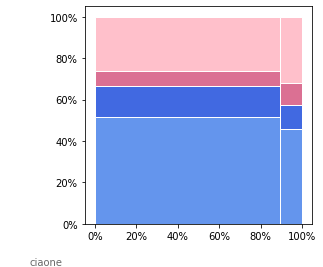

In [120]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots()

ax.set_aspect('equal')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

width = width_movies
r = [width[0]/2, width[0] + width[1]/2]

ax.bar(r, np_male, width = width, color = 'cornflowerblue', edgecolor = 'white', linewidth = 1)
ax.bar(r, p_male, bottom = np_male, width = width, color = 'royalblue', edgecolor = 'white', linewidth = 1)
ax.bar(r, p_fem, bottom = [i+j for i,j in zip(np_male, p_male)], width = width, color = 'palevioletred', edgecolor = 'white', linewidth = 1)
ax.bar(r, np_fem, bottom = [i+j+k for i,j,k in zip(np_male, p_male, p_fem)], width = width, color = 'pink', edgecolor = 'white', linewidth = 1)

# Titles and annotations.

title = ""


ax.annotate("ciaone",
            color='dimgray',
            xy=(0, 0), 
            xycoords='figure fraction',
            xytext=(30, 0),  
            textcoords='offset points',
            ha='left', va='bottom')

plt.savefig("mekko.pdf")